In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import quapy as qp
from freq_e.estimate import (
    calc_log_odds,
    mll_curve,
    generative_get_map_est,
    infer_freq_from_predictions,
    DEFAULT_THETA_GRID,
)
from quapy.error import kld
from quapy.method.aggregative import (
    CC,
    ACC,
    PCC,
    PACC,
    MAX as TH_MAX,
    X as TH_X,
    T50 as TH_T50,
    MS as TH_MS,
    EMQ,
    HDy,
    newELM,
)
from quapy.method.non_aggregative import DMx
from quapy.functional import HellingerDistance
from scipy.stats import gaussian_kde
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

/home/max/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = 'plots_teoria'

# Capítulo 1: Problema

## 1.1. Introducción

In [3]:
random_state = 42
np.random.seed(random_state)

In [4]:
population_size = 150
train_size = 100
prev_test = 0.1

In [5]:
population_config = {
    'n_samples': population_size,
    'class_sep': 0.1,
    'n_classes': 2,
    'n_features': 2,
    'n_informative': 2,
    'n_redundant': 0,
    'n_repeated': 0,
    'n_clusters_per_class': 2,
    'flip_y': 0,
}
population_config

{'n_samples': 150,
 'class_sep': 0.1,
 'n_classes': 2,
 'n_features': 2,
 'n_informative': 2,
 'n_redundant': 0,
 'n_repeated': 0,
 'n_clusters_per_class': 2,
 'flip_y': 0}

In [6]:
X, y = make_classification(
    **population_config,
    weights=None,
    random_state=random_state,
)

In [7]:
y.sum()

75

In [8]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
idx_negatives_test = np.argwhere(y_test==0).flatten()
idx_positives_test = np.random.choice(
    np.argwhere(y_test==1).flatten(),
    size=round((prev_test)*len(idx_negatives_test)/(1-prev_test)),
    replace=False,
)
idx_test = np.concatenate([idx_positives_test, idx_negatives_test])
X_test = X_test[idx_test]
y_test = y_test[idx_test]

In [9]:
print(y_train.sum()/y_train.size)
print(y_test.sum()/y_test.size)

0.53
0.0967741935483871


In [10]:
print(len(y_train))
print(len(y_test))

100
31


In [11]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

In [12]:
y_predict = model.predict(X)
positive_predictions = (y_predict==1)

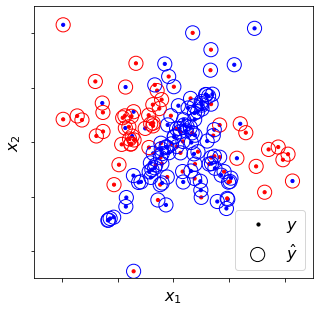

In [13]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors = np.where(y, 'r', 'b')
ground_truth_points = ax.scatter(
    x=X[:, 0],
    y=X[:, 1],
    s=40,
    c=ground_truth_colors,
    marker='.',
)
prediction_colors_test = np.where(y_predict, 'r', 'b')
prediction_circles_test = ax.scatter(
    x=X[:, 0],
    y=X[:, 1],
    s=200,
    marker='o',
    facecolors='None',
    edgecolors=prediction_colors_test,
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points, prediction_circles_test],
    [r'$y$', r'$\hat y$'],
    loc='best',
    fontsize=fontsize,
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.savefig(f'{output_dir}/intro_scatterplot.png')
plt.show()

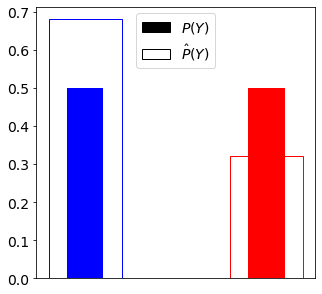

In [14]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

unique, y_counts = np.unique(y, return_counts=True)
_, y_predict_counts = np.unique(y_predict, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_counts/len(y),
    color=colors,
    width=0.2,
)
predictions_bar = ax.bar(
    unique,
    y_predict_counts/len(y),
    edgecolor=colors,
    width=0.4, 
    fill=False,
)
ax.legend(
    [ground_truth_bar, predictions_bar],
    [r'$P(Y)$', r'$\hat P(Y)$'],
    fontsize=fontsize,
    loc='upper center',
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/intro_barplot.png')
plt.show()

## 1.4. Cambios en las distribuciones de los datos

In [15]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [16]:
y_predict_train = model.predict(X_train)
positive_predictions_train = (y_predict_train==1)

In [17]:
y_predict_test = model.predict(X_test)
positive_predictions_test = (y_predict_test==1)

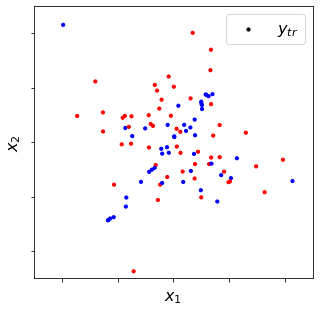

In [18]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors_train = np.where(y_train, 'r', 'b')
ground_truth_points_train = ax.scatter(
    x=X_train[:, 0],
    y=X_train[:, 1],
    s=40,
    c=ground_truth_colors_train,
    marker='.',
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points_train],
    [r'$y_{tr}$'],
    loc='best',
    fontsize=fontsize,
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.savefig(f'{output_dir}/cambios_train_scatterplot.png')
plt.show()

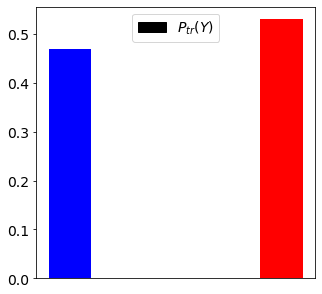

In [19]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

unique, y_counts_train = np.unique(y_train, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_counts_train/len(y_train),
    color=colors,
    width=0.2,
)
ax.legend(
    [ground_truth_bar],
    [r'$P_{tr}(Y)$'],
    loc='upper center',
    fontsize=fontsize,
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/cambios_train_barplot.png')
plt.show()

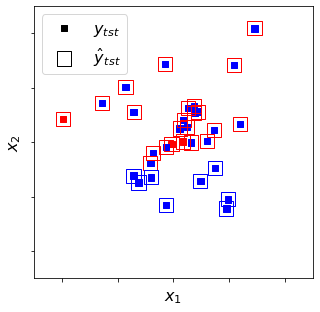

In [20]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 16

ground_truth_colors_test = np.where(y_test, 'r', 'b')
ground_truth_points_test = ax.scatter(
    x=X_test[:, 0],
    y=X_test[:, 1],
    s=40,
    c=ground_truth_colors_test,
    marker='s',
)
prediction_colors_test = np.where(y_predict_test, 'r', 'b')
predictions_squares_test = ax.scatter(
    x=X_test[:, 0],
    y=X_test[:, 1],
    s=200,
    marker='s',
    facecolors='None',
    edgecolors=prediction_colors_test,
)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.xlabel(r'$x_{1}$', fontsize=fontsize)
plt.ylabel(r'$x_{2}$', fontsize=fontsize)
ax.legend(
    [ground_truth_points_test, predictions_squares_test],
    [r'$y_{tst}$', r'$\hat y_{tst}$'],
    loc='best',
    fontsize=fontsize,
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.savefig(f'{output_dir}/cambios_test_scatterplot.png')
plt.show()

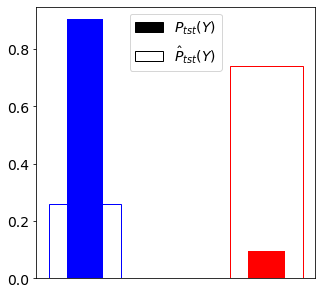

In [21]:
f, ax = plt.subplots(1)
f.set_size_inches(5, 5)
fontsize = 14

_, y_counts_test = np.unique(y_test, return_counts=True)
_, y_counts_predict_test = np.unique(y_predict_test, return_counts=True)

ax.xaxis.set_visible(False)
colors = ['blue', 'red']
ground_truth_bar = ax.bar(
    unique,
    y_counts_test/len(y_test),
    color=colors,
    width=0.2,
)
predictions_bar = ax.bar(
    unique,
    y_counts_predict_test/len(y_test),
    edgecolor=colors,
    width=0.4, 
    fill=False,
)
ax.legend(
    [ground_truth_bar, predictions_bar],
    [r'$P_{tst}(Y)$', r'$\hat P_{tst}(Y)$'],
    loc='upper center',
    fontsize=fontsize,
)
ax.tick_params(labelsize=fontsize)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/cambios_test_barplot.png')
plt.show()

## 1.5. El problema de clasificar y contar

In [22]:
p_vals = np.round(np.arange(0, 1.05, 0.05), 2)
tpr_vals = np.round(np.arange(0.6, 1.01, 0.2), 1)
fpr_vals = np.round(np.arange(0, 0.41, 0.2), 1)

In [23]:
# Compute the formula for all possible combinations using broadcasting
p_hat_vals = (
    p_vals[:, np.newaxis, np.newaxis] * tpr_vals[np.newaxis, :, np.newaxis] +
    (1-p_vals[:, np.newaxis, np.newaxis])*fpr_vals[np.newaxis, np.newaxis, :]
)

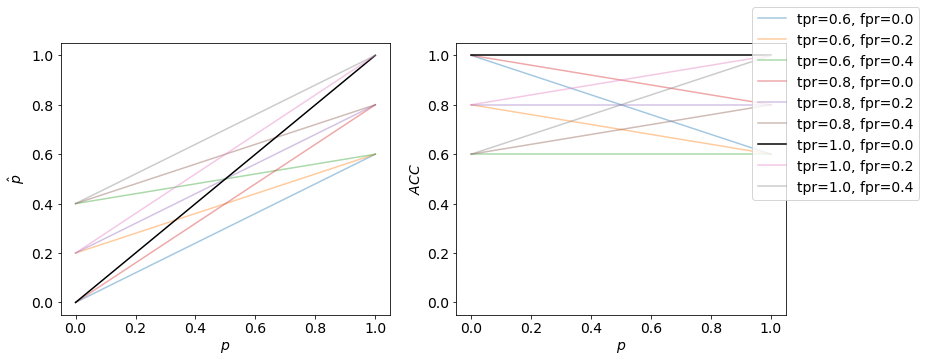

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(13, 5)
fontsize = 14
default_alpha = 0.4
loc = plticker.MultipleLocator(base=0.1)

for i in range(0, len(tpr_vals)):
    for j in range(0, len(fpr_vals)):
        alpha = default_alpha
        color = None
        if tpr_vals[i]==1 and fpr_vals[j]==0:
            alpha = 1
            color = 'black'
        ax1.plot(
            p_vals,
            p_hat_vals[:, i, j],
            label=f'tpr={tpr_vals[i]:.1f}, fpr={fpr_vals[j]:.1f}',
            alpha=alpha,
            color=color,
        )
ax1.set_xlabel(r'$p$', fontsize = fontsize)
ax1.set_ylabel(r'$\hat p$', fontsize = fontsize)
ax1.tick_params(labelsize = fontsize)

for i in range(0, len(tpr_vals)):
    for j in range(0, len(fpr_vals)):
        alpha = default_alpha
        color = None
        if tpr_vals[i]==1 and fpr_vals[j]==0:
            alpha = 1
            color = 'black'
        ax2.plot(
            p_vals,
            (tpr_vals[i]*p_vals)+(1-fpr_vals[j])*(1-p_vals),
            label=f'tpr={tpr_vals[i]:.1f}, fpr={fpr_vals[j]:.1f}',
            alpha=alpha,
            color=color,
        )
ax2.set_xlabel(r'$p$', fontsize = fontsize)
ax2.set_ylabel(r'$ACC$', fontsize = fontsize)
ax2.tick_params(labelsize = fontsize)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor=(1.05, 1), fontsize=fontsize)

plt.savefig(f'{output_dir}/cc_tpr_fpr.png', bbox_inches='tight')
plt.show()

In [25]:
population_config_1d = {
    'n_samples': population_size,
    'class_sep': 0.1,
    'n_classes': 2,
    'n_features': 1,
    'n_informative': 1,
    'n_redundant': 0,
    'n_repeated': 0,
    'n_clusters_per_class': 1,
}
X_1d, y_1d = make_classification(
    **population_config_1d,
    weights=None,
    random_state=random_state,
)
X_1d = X_1d.flatten()

X_train_1d, y_train_1d = X_1d[:train_size], y_1d[:train_size]
X_test_1d, y_test_1d = X_1d[train_size:], y_1d[train_size:]
idx_negatives_test_1d = np.argwhere(y_test_1d==0).flatten()
idx_positives_test_1d = np.random.choice(
    np.argwhere(y_test_1d==1).flatten(),
    size=round((prev_test)*len(idx_negatives_test_1d)/(1-prev_test)),
    replace=False,
)
idx_test_1d = np.concatenate([idx_positives_test_1d, idx_negatives_test_1d])
X_test_1d = X_test_1d[idx_test_1d]
y_test_1d = y_test_1d[idx_test_1d]

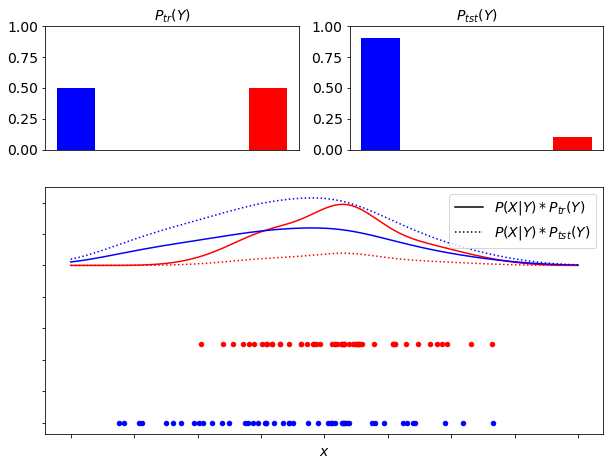

In [26]:

f = plt.figure()
fontsize = 14
f.set_size_inches(10, 7.5)
colors = ['blue', 'red']

gs = f.add_gridspec(2,2,height_ratios=[1,2])
ax0 = f.add_subplot(gs[1,:])
ax1 = f.add_subplot(gs[0,0])
ax2 = f.add_subplot(gs[0,1])

xs = np.linspace(-2,2,200)
ax0.scatter(
    x=X_train_1d[y_train_1d==1],
    y=[-0.5]*sum(y_train_1d==1),
    c=colors[1],
    marker='o',
    s=20,
)
ax0.scatter(
    x=X_train_1d[y_train_1d==0],
    y=[-1]*sum(y_train_1d==0),
    c=colors[0],
    marker='o',
    s=20,
)
ax0.plot(
    xs,
    gaussian_kde(X_train_1d[y_train_1d==1])(xs) * 0.5,
    color=colors[1],
    linestyle='-',
    label=r'$P(X|Y)*P_{tr}(Y)$',
)
ax0.plot(
    xs,
    gaussian_kde(X_train_1d[y_train_1d==0])(xs) * 0.5,
    color=colors[0],
    linestyle='-',
)
ax0.plot(
    xs,
    gaussian_kde(X_train_1d[y_train_1d==1])(xs) * 0.1,
    color=colors[1],
    linestyle=':',
    label=r'$P(X|Y)*P_{tst}(Y)$',
)
ax0.plot(
    xs,
    gaussian_kde(X_train_1d[y_train_1d==0])(xs) * 0.9,
    color=colors[0],
    linestyle=':',
)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.legend(
    loc='upper right',
    fontsize=fontsize,
)
leg = ax0.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
ax0.set_xlabel(r'$x$', fontsize=fontsize)
ax0.tick_params(labelsize=fontsize)

ax1.xaxis.set_visible(False)
ax1.bar(
    [0, 1],
    [0.5, 0.5],
    color=colors,
    width=0.2,
)
ax1.set_ylim([0, 1])
ax1.set_title(r'$P_{tr}(Y)$', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)

ax2.xaxis.set_visible(False)
ax2.bar(
    [0, 1],
    [0.9, 0.1],
    color=colors,
    width=0.2,
)
ax2.set_ylim([0, 1])
ax2.set_title(r'$P_{tst}(Y)$', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
plt.savefig(f'{output_dir}/bayes_classifier.png')
plt.show()

# Capítulo 2: Estimación Puntual

In [27]:
X_ab, X_c, y_ab, y_c = train_test_split(X_train, y_train, test_size = 0.15, stratify=y_train, random_state=random_state)
X_a, X_b, y_a, y_b = train_test_split(X_ab, y_ab, test_size = 0.176, stratify=y_ab, random_state=random_state) # 0.85*0.176=0.15
# a: 70%, b: 15%, c: 15%

In [28]:
#CC:
## No necesita dataset para calibrar ni cuantificar
### Cuantifico
#### Manualmente
hat_p_cc = y_counts_predict_test[1]/len(y_test)
#### Con QuaPy
hat_p_cc_qp = CC(model).aggregate(y_predict_test)[1]
### Resultados
{
    'frac': f"{y_counts_predict_test[1]}/{len(y_test)}",
    'hat_p_cc': hat_p_cc,
    'hat_p_cc_qp': hat_p_cc_qp,
}

{'frac': '23/31',
 'hat_p_cc': 0.7419354838709677,
 'hat_p_cc_qp': 0.7419354838709677}

In [29]:
#ACC:
## Necesita dataset para cuantificar
### Creo nuevo modelo con 85% de datos, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
y_predict_test = model.predict(X_test)
_, y_counts_predict_test = np.unique(y_predict_test, return_counts=True)
hat_p_cc = y_counts_predict_test[1]/len(y_test)
### Ajusto modelo cuantificador con el 15%
#### Manualmente
y_predict_c = model.predict(X_c)
tn, fp, fn, tp = confusion_matrix(y_c, y_predict_c).ravel()
print({
    "tn": tn,
    "fp": fp,
    "fn": fn,
    "tp": tp,
})
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
### Cuantifico
hat_p_acc = (hat_p_cc-fpr)/(tpr-fpr)
#### Con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_c, y_c)
qp_tr_data = classif_predictions
qp_acc = ACC(model)
qp_acc.aggregation_fit(classif_predictions, qp_tr_data)
### Cuantifico
hat_p_acc_qp = qp_acc.aggregate(y_predict_test)[1]
### Resultados
{
    "fpr": fpr,
    "tpr": tpr,
    'hat_p_cc': hat_p_cc,
    "hat_p_acc": hat_p_acc,
    'hat_p_acc_qp': hat_p_acc_qp,
}

{'tn': 2, 'fp': 5, 'fn': 3, 'tp': 5}


{'fpr': 0.7142857142857143,
 'tpr': 0.625,
 'hat_p_cc': 0.7096774193548387,
 'hat_p_acc': 0.051612903225806216,
 'hat_p_acc_qp': 0.051612890817447986}

In [30]:
#PCC
## Necesita dataset para calibrar
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_proba_test = model.predict_proba(X_test)
s = pd.DataFrame(y_predict_proba_test).transpose()
print(s.to_latex(
    header=False,
    bold_rows=True,
    float_format="%.2f",
))
### Cuantifico
#### Manualmente
hat_p_pcc = y_predict_proba_test[:, 1].mean()
#### Con QuaPy
hat_p_pcc_qp = PCC(model).aggregate(y_predict_proba_test)[1]
### Resultados
{
    'hat_p_pcc': hat_p_pcc,
    'hat_p_pcc_qp': hat_p_pcc_qp,
}

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
\textbf{0} & 0.46 & 0.46 & 0.51 & 0.50 & 0.55 & 0.44 & 0.43 & 0.40 & 0.48 & 0.50 & 0.42 & 0.46 & 0.49 & 0.46 & 0.48 & 0.42 & 0.44 & 0.43 & 0.48 & 0.49 & 0.41 & 0.48 & 0.50 & 0.55 & 0.48 & 0.53 & 0.46 & 0.59 & 0.40 & 0.45 & 0.51 \\
\textbf{1} & 0.54 & 0.54 & 0.49 & 0.50 & 0.45 & 0.56 & 0.57 & 0.60 & 0.52 & 0.50 & 0.58 & 0.54 & 0.51 & 0.54 & 0.52 & 0.58 & 0.56 & 0.57 & 0.52 & 0.51 & 0.59 & 0.52 & 0.50 & 0.45 & 0.52 & 0.47 & 0.54 & 0.41 & 0.60 & 0.55 & 0.49 \\
\bottomrule
\end{tabular}



{'hat_p_pcc': 0.5269941054203539, 'hat_p_pcc_qp': 0.526994105420354}

In [31]:
#PACC
## Necesita dataset para cuantificar y para calibrar
### Creo nuevo modelo con 60% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_a, y_a)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_b, y_b)
y_predict_proba_test = model.predict_proba(X_test)
hat_p_pcc = y_predict_proba_test[:, 1].mean()
### Ajusto modelo cuantificador con el 15%
#### Manualmente
y_predict_c = model.predict(X_c)
y_predict_proba_c = model.predict_proba(X_c)
s = pd.DataFrame({
    "h(x)=0": y_predict_proba_c[:, 0],
    "h(x)=1": y_predict_proba_c[:, 1],
    "y": y_predict_c,
})
print(s.to_latex(
    index=False,
    float_format="%.2f",
))
tppa = y_predict_proba_c[y_c==1, 1].sum()/(y_c==1).sum()
fppa = y_predict_proba_c[y_c==0, 1].sum()/(y_c==0).sum()
#### Cuantifico
hat_p_pacc = (hat_p_pcc-fppa)/(tppa-fppa)
#### Con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_proba_c, y_c)
qp_tr_data = classif_predictions
qp_pacc = PACC(model)
qp_pacc.aggregation_fit(classif_predictions, qp_tr_data)
#### Cuantifico
hat_p_pacc_qp = qp_pacc.aggregate(y_predict_proba_test)[1]
### Resultados
{
    "tppa": tppa,
    "fppa": fppa,
    'hat_p_pcc': hat_p_pcc,
    "hat_p_pacc": hat_p_pacc,
    'hat_p_pacc_qp': hat_p_pacc_qp,
}

\begin{tabular}{rrr}
\toprule
 h(x)=0 &  h(x)=1 &  y \\
\midrule
   0.23 &    0.77 &  1 \\
   0.78 &    0.22 &  0 \\
   0.40 &    0.60 &  1 \\
   0.43 &    0.57 &  1 \\
   0.32 &    0.68 &  1 \\
   0.48 &    0.52 &  1 \\
   0.55 &    0.45 &  0 \\
   0.44 &    0.56 &  1 \\
   0.58 &    0.42 &  0 \\
   0.70 &    0.30 &  0 \\
   0.48 &    0.52 &  1 \\
   0.41 &    0.59 &  1 \\
   0.21 &    0.79 &  1 \\
   0.16 &    0.84 &  1 \\
   0.58 &    0.42 &  0 \\
\bottomrule
\end{tabular}



{'tppa': 0.5507672296090962,
 'fppa': 0.5483745129070783,
 'hat_p_pcc': 0.5743518951632147,
 'hat_p_pacc': 10.856856657634534,
 'hat_p_pacc_qp': 0.9999999999999998}

In [32]:
# Seleccion de umbrales
## Necesita dataset para cuantificar
### Creo nuevo modelo con 85% de datos, y predigo para test set

# workaround for making predict_proba-only classifiers work in quapy:
class GaussianNBwrap(GaussianNB):
    def decision_function(self, X):
        assert len(self.classes_)==2, 'wrong number of classes'
        return self.predict_proba(X)[:,1]

model = GaussianNBwrap()
model.fit(X_ab, y_ab)
y_decision_function_c = model.decision_function(X_c)
y_decision_function_test = model.decision_function(X_test)
fprs, tprs, ths = roc_curve(y_c, y_decision_function_c)

idx_dict = {}
th_dict = {}
tpr_dict = {}
fpr_dict = {}

idx_dict['MAX'] = np.argmin(fprs - tprs)
max_val = np.max(tprs - fprs)
idx_dict['X'] = np.argmin(np.abs(1 - np.array(tprs + fprs)))
idx_dict['T50'] = np.argmin(np.abs(np.array(tprs)-0.5))

for key, val in idx_dict.items():
    th_dict[key] = ths[val]
    fpr_dict[key] = fprs[val]
    tpr_dict[key] = tprs[val]

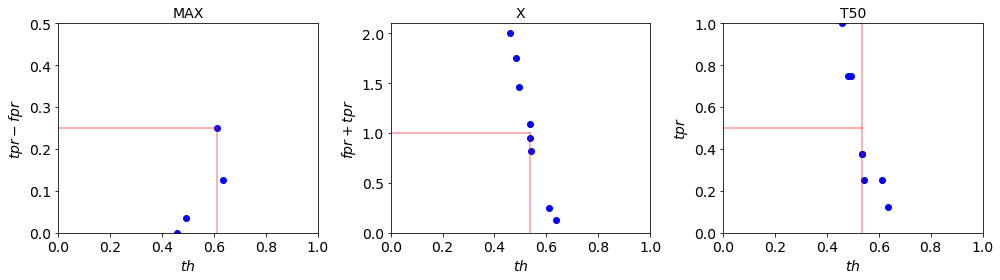

Thresholds:  {'MAX': 0.6113187067919104, 'X': 0.5365932816236412, 'T50': 0.5365932816236412}


In [33]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

ax1.plot(
    ths,
    tprs - fprs,
    'o',
    color='b',
)
ax1.plot(
    [0, th_dict['MAX']],
    [max_val, max_val],
    alpha=alpha,
    color='r',
)
ax1.plot(
    [th_dict['MAX'], th_dict['MAX']],
    [0, max_val],
    alpha=alpha,
    color='r',
)
ax1.set_xlabel(r'$th$', fontsize = fontsize)
ax1.set_ylabel(r'$tpr - fpr$', fontsize = fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 0.5])
ax1.tick_params(labelsize = fontsize)
ax1.set_title('MAX', fontsize = fontsize)
ax1.tick_params(labelsize=fontsize)

ax2.plot(
    ths,
    fprs + tprs,
    'o',
    color='b',
)
ax2.plot(
    [0, th_dict['X']],
    [1, 1],
    alpha=alpha,
    color='r',
)
ax2.plot(
    [th_dict['X'], th_dict['X']],
    [0, 1],
    alpha=alpha,
    color='r',
)
ax2.set_xlabel(r'$th$', fontsize = fontsize)
ax2.set_ylabel(r'$fpr + tpr$', fontsize = fontsize)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 2.1])
ax2.tick_params(labelsize = fontsize)
ax2.set_title('X', fontsize = fontsize)
ax2.tick_params(labelsize=fontsize)

ax3.plot(
    ths,
    tprs,
    'o',
    color='b',
)
ax3.plot(
    [0, th_dict['T50']],
    [0.5, 0.5],
    alpha=alpha,
    color='r',
)
ax3.plot(
    [th_dict['T50'], th_dict['T50']],
    [0, 1.0],
    alpha=alpha,
    color='r',
)
ax3.set_xlabel(r'$th$', fontsize = fontsize)
ax3.set_ylabel(r'$tpr$', fontsize = fontsize)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.0])
ax3.tick_params(labelsize = fontsize)
ax3.set_title('T50', fontsize = fontsize)
ax3.tick_params(labelsize=fontsize)

f.tight_layout()
plt.savefig(f'{output_dir}/seleccion_umbrales_max_x_t50.png', bbox_inches='tight')
plt.show()
print("Thresholds: ", th_dict)

In [34]:
hat_p_dict = {}
for method in idx_dict.keys():
    hat_p = (y_decision_function_test >= th_dict[method]).mean()
    hat_p_dict[method] = (hat_p-fpr_dict[method])/(tpr_dict[method]-fpr_dict[method])
print("hat_p: ", hat_p_dict)

hat_p:  {'MAX': 0.7741935483870968, 'X': 0.281524926686217, 'T50': 0.281524926686217}


In [35]:
hat_p_vs_th = []
valid_idxs = []
for idx, th in enumerate(ths):
    aux = (y_decision_function_test >= th).mean()
    hat_p = (aux-fprs[idx])/(tprs[idx]-fprs[idx])
    if not np.isnan(hat_p) and (hat_p >= 0) and (hat_p <= 1):
        hat_p_vs_th.append(hat_p)
        valid_idxs.append(idx)
ths = ths[valid_idxs]
tprs = tprs[valid_idxs]
fprs = fprs[valid_idxs]
hat_p_vs_th

/tmp/ipykernel_1062132/1870854561.py:5: RuntimeWarning: invalid value encountered in scalar divide
  hat_p = (aux-fprs[idx])/(tprs[idx]-fprs[idx])
/tmp/ipykernel_1062132/1870854561.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  hat_p = (aux-fprs[idx])/(tprs[idx]-fprs[idx])


[0.7741935483870968,
 0.17204301075268813,
 0.281524926686217,
 0.5840407470288626]

In [36]:
hat_p_ms = np.nanmedian(hat_p_vs_th)
hat_p_dict['MS'] = hat_p_ms

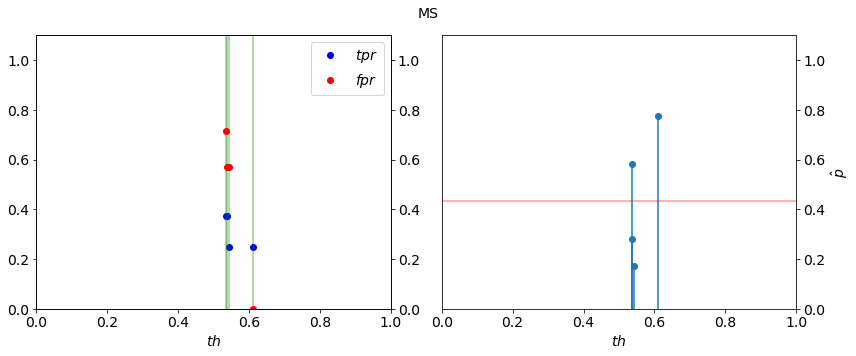

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)
fontsize = 14
alpha = 0.4

tpr_plot = ax1.plot(
    ths,
    tprs,
    'o',
    color = 'b',
    label=r'$tpr$',
)
ax1b = ax1.twinx()
fpr_plot = ax1b.plot(
    ths,
    fprs,
    'o',
    color = 'r',
    label=r'$fpr$',
)
ax1.set_xlabel(r'$th$', fontsize = fontsize)
ax1.tick_params(labelsize = fontsize)
ax1b.tick_params(labelsize = fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.1])
ax1b.set_ylim([0, 1.1])
h1, l1 = ax1.get_legend_handles_labels()
h1b, l1b = ax1b.get_legend_handles_labels()
ax1.vlines(
    ths,
    ymin=0,
    ymax=1.1,
    alpha=alpha,
    color='g',
)
ax1.legend(h1+h1b, l1+l1b, loc='best', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)

ax2.stem(
    ths,
    hat_p_vs_th,
    basefmt=" ",
)
ax2.plot(
    [0, 1.0],
    [hat_p_ms, hat_p_ms],
    alpha=alpha,
    color='r',
)
ax2.set_xlabel(r'$th$', fontsize = fontsize)
ax2.set_ylabel(r'$\hat p$', fontsize = fontsize)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.1])
ax2.tick_params(labelsize = fontsize)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(labelsize=fontsize)

f.suptitle('MS', fontsize = fontsize)
f.tight_layout()
plt.savefig(f'{output_dir}/seleccion_umbrales_ms.png')
plt.show()

In [38]:
hat_p_dict

{'MAX': 0.7741935483870968,
 'X': 0.281524926686217,
 'T50': 0.281524926686217,
 'MS': 0.43278283685753977}

In [39]:
classif_predictions = qp.data.LabelledCollection(y_decision_function_c, y_c)
qp_tr_data = classif_predictions

qp_methods = {'MAX': TH_MAX, 'X': TH_X, 'T50': TH_T50, 'MS': TH_MS}
hat_p_qp = {}

for key, func in qp_methods.items():
    qp_method = func(model)
    qp_method.aggregation_fit(classif_predictions, qp_tr_data)
    hat_p_qp[key] = qp_method.aggregate(y_decision_function_test)[1]

hat_p_qp


{'MAX': 0.7741935483870968,
 'X': 0.281524926686217,
 'T50': 0.924731182795699,
 'MS': 0.5285795132993775}

In [40]:
#EMQ
## Necesita dataset para calibrar (no ajusta para cuantificar, pero necesita el set de entrenamiento)
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_test = model.predict(X_test)
y_predict_proba_test = model.predict_proba(X_test)
y_predict_proba_train = model.predict_proba(X_train)
print(y_predict_proba_test[:, 1].mean())
print(y_predict_proba_test[0, 1])
### Cuantifico con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_proba_test, y_test)
qp_tr_data = qp.data.LabelledCollection(y_predict_proba_train, y_train)
qp_emq = EMQ(model)
qp_emq.aggregation_fit(classif_predictions, qp_tr_data)
hat_p_emq_qp = qp_emq.aggregate(y_predict_proba_test)[1]
{
    'hat_p_emq_qp': hat_p_emq_qp,
}

0.5269941054203539
0.5387890193715169


{'hat_p_emq_qp': 0.16427601035745792}

In [41]:
#HDy
## Necesita dataset para calibrar (no ajusta para cuantificar, pero necesita el set de entrenamiento)
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_test = model.predict(X_test)
y_predict_proba_train = model.predict_proba(X_train)
y_predict_proba_test = model.predict_proba(X_test)
### Cuantifico con QuaPy
classif_predictions = qp.data.LabelledCollection(y_predict_proba_test, y_test)
qp_tr_data = qp.data.LabelledCollection(y_predict_proba_train, y_train)
qp_hdy = HDy(model)
qp_hdy.aggregation_fit(classif_predictions, qp_tr_data)
#### Cuantifico
hat_p_hdy_qp = qp_hdy.aggregate(y_predict_proba_test)[1]
{
    'hat_p_hdy_qp': hat_p_hdy_qp,
}

{'hat_p_hdy_qp': 0.1}

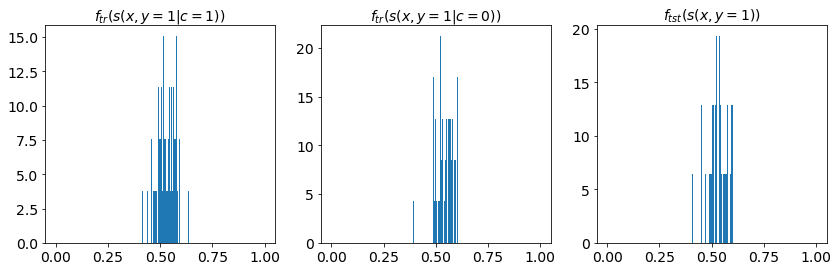

In [42]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

bins = 200

counts_1, bins_1, bars_1 = ax1.hist(y_predict_proba_train[y_train==1][:,1], bins=bins, range=(0,1), density=True)
ax1.set_title(r"$f_{tr}{(s(x,y=1|c=1)})$", fontsize=fontsize)
counts_2, bins_2, bars_2 = ax2.hist(y_predict_proba_train[y_train==0][:,1], bins=bins, range=(0,1), density=True)
ax2.set_title(r"$f_{tr}{(s(x,y=1|c=0)})$", fontsize=fontsize)
counts_3, bins_3, bars_3 = ax3.hist(y_predict_proba_test[:,1], bins=bins, range=(0,1), density=True)
ax3.set_title(r"$f_{tst}{(s(x,y=1)})$", fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.tick_params(labelsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
plt.savefig(f'{output_dir}/hdy_1.png')
plt.show()

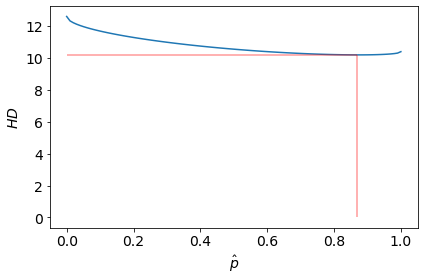

0.87

In [43]:
ps = np.linspace(0, 1, 101)
hds = [None] * len(ps)
for idx, p in enumerate(ps):
    merged = counts_1*p+counts_2*(1-p)
    hds[idx] = HellingerDistance(merged, counts_3)
plt.plot(ps, hds)
plt.xlabel(r'$\hatp$', fontsize = fontsize)
plt.ylabel(r'$\it{HD}$', fontsize = fontsize)
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.vlines(
    ps[np.argmin(hds)],
    ymin=0.0,
    ymax=np.min(hds),
    alpha=alpha,
    color='r',
)
plt.hlines(
    np.min(hds),
    xmin=0.0,
    xmax=ps[np.argmin(hds)],
    alpha=alpha,
    color='r',
)
fig.tight_layout()
fig.savefig(f'{output_dir}/hdy_2.png')
plt.show()

hat_p_hdy = ps[np.argmin(hds)]
hat_p_hdy

/home/max/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


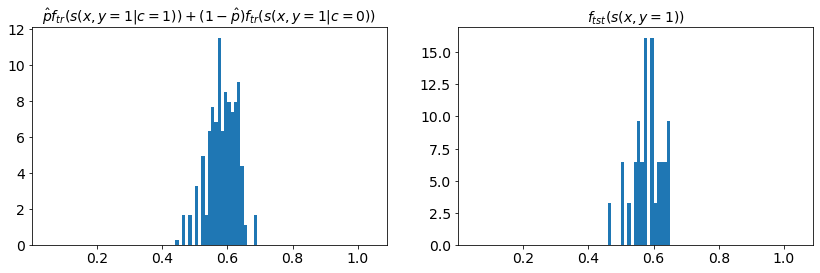

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

p = hat_p_hdy
merged = counts_1*p+counts_2*(1-p)
bins_aux = np.round((bins_1[:-1]+0.05),2)
ax1.hist(bins_aux, bins=bins_aux, weights=merged, density=True)
ax1.set_title(r"$\hat{p} f_{tr}{(s(x,y=1|c=1))}+(1-\hat{p}) f_{tr}{(s(x,y=1|c=0))}$", fontsize=fontsize)
ax2.hist(bins_aux, bins=bins_aux, weights=counts_3, density=True)
ax2.set_title(r"$f_{tst}{(s(x,y=1)})$", fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)

plt.savefig(f'{output_dir}/hdy_3.png')
plt.show()

In [45]:
#ELM
## Con clasificador específico, no usa clasificador previo
qp.environ['SVMPERF_HOME'] = '/home/max/my_projects/QuaPy/svm_perf_quantification'
qp_svmkld = newELM(qp.environ['SVMPERF_HOME'], loss='kld')
qp_data_train = qp.data.LabelledCollection(X_train, y_train)
qp_svmkld.fit(qp_data_train)
### Cuantifico
#### Con QuaPy
hat_p_svmkld_qp = qp_svmkld.quantify(X_test)[1]
### Resultados
print({
    'hat_p_svmkld_qp': hat_p_svmkld_qp,
})

qp.environ["SAMPLE_SIZE"] = len(y_test)

print(r'$KLD_{CC}:$', kld(np.array([0.9, 0.1]), np.array([1-hat_p_cc_qp, hat_p_cc_qp])))
print(r'$KLD_{SVM_{perfKL}}:$', kld(np.array([0.9, 0.1]), np.array([1-hat_p_svmkld_qp, hat_p_svmkld_qp])))

{'hat_p_svmkld_qp': 0.6129032258064516}
$KLD_{CC}:$ 0.8595541564680089
$KLD_{SVM_{perfKL}}:$ 0.5382696247501692


In [46]:
#HDx
# Sale todo de la data de entrenamiento y X_test, no usa nada de modelo de clasificacion

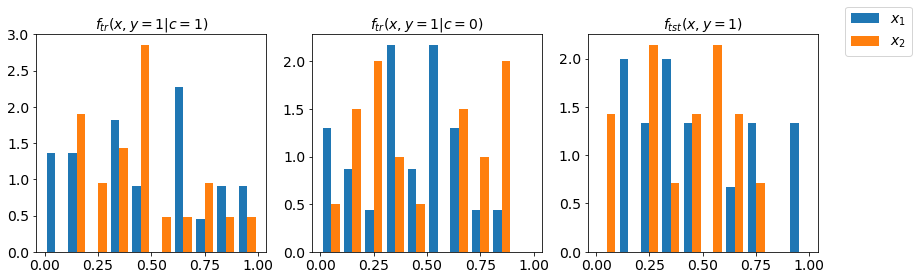

In [47]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

bins = 10

counts_1, bins_1, bars_1 = ax1.hist(X_train[y_train==1], bins=bins, range=(0,1), density=True, label=(r"$x_1$", r"$x_2$"))
ax1.set_title(r"$f_{tr}{(x,y=1|c=1)}$", fontsize=fontsize)
counts_2, bins_2, bars_2 = ax2.hist(X_train[y_train==0], bins=bins, range=(0,1), density=True)
ax2.set_title(r"$f_{tr}{(x,y=1|c=0)}$", fontsize=fontsize)
counts_3, bins_3, bars_3 = ax3.hist(X_test, bins=bins, range=(0,1), density=True)
ax3.set_title(r"$f_{tst}{(x,y=1)}$", fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.tick_params(labelsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=fontsize)
plt.savefig(f'{output_dir}/hdx_1.png')
plt.show()

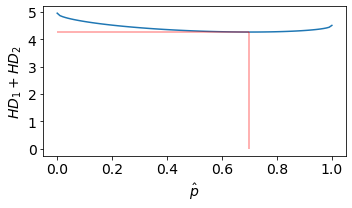

0.7000000000000001

In [48]:
ps = np.linspace(0, 1, 101)
hds = [None] * len(ps)
for idx, p in enumerate(ps):
    merged = counts_1*p+counts_2*(1-p)
    hds[idx] = HellingerDistance(merged[0], counts_3[0]) + HellingerDistance(merged[1], counts_3[1])
plt.plot(ps, hds)
plt.xlabel(r'$\hatp$', fontsize = fontsize)
plt.ylabel(r'$\it{{HD_1}+{HD_2}}$', fontsize = fontsize)
fig = plt.gcf()
fig.set_size_inches(5, 3)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.vlines(
    ps[np.argmin(hds)],
    ymin=0.0,
    ymax=np.min(hds),
    alpha=alpha,
    color='r',
)
plt.hlines(
    np.min(hds),
    xmin=0.0,
    xmax=ps[np.argmin(hds)],
    alpha=alpha,
    color='r',
)
fig.tight_layout()
fig.savefig(f'{output_dir}/hdx_2.png')
plt.show()

hat_p_hdx = ps[np.argmin(hds)]
hat_p_hdx

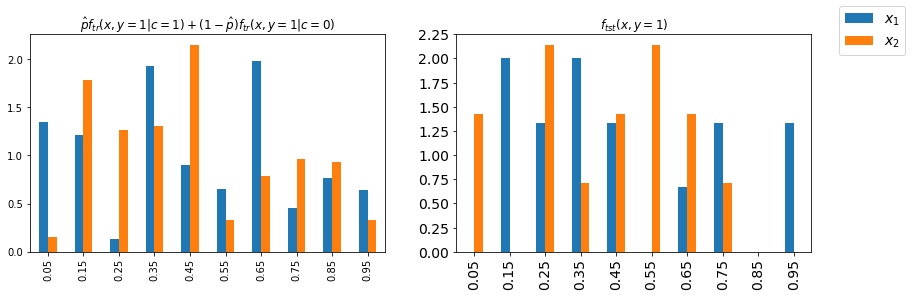

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(14, 4)
fontsize = 14
alpha = 0.4

p = hat_p_hdx
merged = counts_1*p+counts_2*(1-p)
bins_aux = np.round((bins_1[:-1]+0.05),2)
pd_merged = pd.DataFrame(index=bins_aux, data={r"$x_1$": merged[0], r"$x_2$": merged[1]})
pd_merged.plot(kind='bar', ax=ax1, title=r"$\hat{p} f_{tr}{(x,y=1|c=1)}+(1-\hat{p}) f_{tr}{(x,y=1|c=0)}$", legend=False)

pd_merged = pd.DataFrame(index=bins_aux, data={r"$x_1$": counts_3[0], r"$x_2$": counts_3[1]})
pd_merged.plot(kind='bar', ax=ax2, title=r"$f_{tst}{(x,y=1})$", legend=False)

handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(f'{output_dir}/hdx_3.png')
plt.show()

In [50]:
qp_tr_data = qp.data.LabelledCollection(X_train, y_train)
qp_hdx = DMx.HDx().fit(qp_tr_data)
hat_p_hdx_qp = qp_hdx.quantify(X_test)[1]
hat_p_hdx_qp

0.5050505050505051

In [51]:
# LR-Implicit
## Necesita dataset para calibrar (no ajusta para cuantificar, pero necesita el set de entrenamiento)
### Creo nuevo modelo con 85% de datos, calibro con 15%, y predigo para test set
model = GaussianNB()
model.fit(X_ab, y_ab)
model = CalibratedClassifierCV(model, cv="prefit")
model.fit(X_c, y_c)
y_predict_test = model.predict(X_test)
y_predict_proba_test = model.predict_proba(X_test)

y_train_prev = y_train.mean()

In [52]:
freqe_result = infer_freq_from_predictions(y_predict_proba_test[:, 1], y_train_prev)
freqe_result


{'point': 0.14, 'conf_interval': (0.0, 0.937), 'conf_level': 0.95}

In [53]:
log_odds = calc_log_odds(y_predict_proba_test[:, 1])
mll_curve_values = mll_curve(log_odds, y_train_prev)
generative_get_map_est(mll_curve_values)

0.14

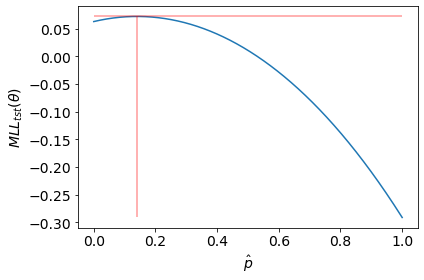

0.14

In [54]:
fontsize = 14
alpha = 0.4

plt.plot(DEFAULT_THETA_GRID, mll_curve_values)
plt.xlabel(r'$\hatp$', fontsize = fontsize)
plt.ylabel(r'$\it{{MLL}_{tst}(\theta)}$', fontsize = fontsize)
fig = plt.gcf()
fig.set_size_inches(6, 4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.vlines(
    freqe_result['point'],
    ymin=np.min(mll_curve_values),
    ymax=np.max(mll_curve_values),
    alpha=alpha,
    color='r',
)
plt.hlines(
    np.max(mll_curve_values),
    xmin=0.0,
    xmax=1,
    alpha=alpha,
    color='r',
)
fig.tight_layout()
fig.savefig(f'{output_dir}/lr_implicit.png')
plt.show()

freqe_result['point']

# Apendice A: Calibracion

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [56]:
lr = LogisticRegression()
gnb = GaussianNB()
boosting = GradientBoostingClassifier()
rfc = RandomForestClassifier()

clf_dic = {
     "Logistic": lr,
     "Naive Bayes":gnb,
     "Gradient Boosting":boosting,
     "Random forest":rfc,
}

In [57]:
def uncalibrated(trainX, testX, trainy, model):
    model.fit(trainX, trainy)
    return model.predict_proba(testX)[:, 1]

In [58]:
# predict calibrated probabilities
def calibrated(trainX, testX, trainy, model, method):
	calibrated = CalibratedClassifierCV(model, method=method, cv=5)
	calibrated.fit(trainX, trainy)
	# predict probabilities
	return calibrated.predict_proba(testX)[:, 1]

In [59]:
X, y = make_classification(
    n_samples=10000,
    n_features=10, 
    n_informative=2,
    n_redundant=8, 
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.50, 
    random_state=42)

In [60]:
df_uncalibrated = pd.DataFrame()

In [61]:
for key, value in clf_dic.items():
    df_uncalibrated[key] = uncalibrated(X_train, X_test, y_train, value)

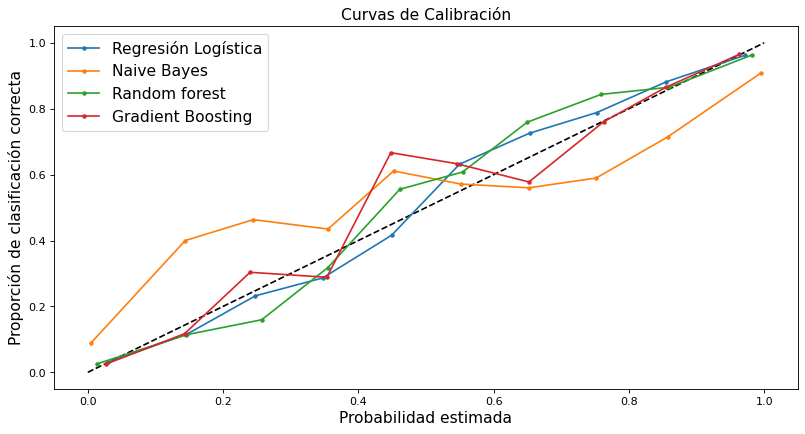

In [62]:
# plot perfectly calibrated
figure(figsize=(12, 6), dpi=80)
fontsize = 14
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(calibration_curve(y_test,  df_uncalibrated["Logistic"], n_bins=10, strategy='uniform')[1], 
         calibration_curve(y_test, df_uncalibrated["Logistic"], n_bins=10, strategy='uniform')[0], marker='.', label="Regresión Logística")

plt.plot(calibration_curve(y_test,  df_uncalibrated["Naive Bayes"], n_bins=10, strategy='uniform')[1], 
         calibration_curve(y_test, df_uncalibrated["Naive Bayes"], n_bins=10, strategy='uniform')[0], marker='.', label="Naive Bayes")

plt.plot(calibration_curve(y_test, df_uncalibrated["Random forest"], n_bins=10, strategy='uniform')[1], 
         calibration_curve(y_test, df_uncalibrated["Random forest"], n_bins=10, strategy='uniform')[0], marker='.', label="Random forest")

plt.plot(calibration_curve(y_test, df_uncalibrated["Gradient Boosting"], n_bins=10, strategy='uniform')[1], 
         calibration_curve(y_test, df_uncalibrated["Gradient Boosting"], n_bins=10, strategy='uniform')[0], marker='.', label="Gradient Boosting")

plt.title("Curvas de Calibración", fontsize=fontsize)
plt.xlabel("Probabilidad estimada", fontsize=fontsize)
plt.ylabel("Proporción de clasificación correcta", fontsize=fontsize)
plt.legend(loc="upper left", fontsize=fontsize)
plt.savefig(f'{output_dir}/curvas_de_calibracion.png')
plt.show()